In [243]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)

from typing import *
from utils.datagen import SignalGenerator
import numpy as np
import scipy as sp
from utils import sample_with_minimum_distance
from utils.signal import band_limited_noise, random_walk
import random
import mne
from alltools.console.colored import warn


def make_artifacts(tc, center_coords, ratio, artifact_len, max_freq, additional_noise=0):
    if not isinstance(center_coords, (list, tuple, np.ndarray)):
        center_coords = [center_coords]

    artifacts_bounds = []

    for center in center_coords:
        artifact_startsample = int(max(center - artifact_len//2, 0))
        artifact_endsample = artifact_startsample + artifact_len

        if artifact_endsample >= len(tc):
            artifact_endsample = 0

        noise = band_limited_noise(np.random.randint(0, max_freq//2), max_freq, len(tc), 1/500)
        changed_len = len(tc[artifact_startsample:artifact_endsample - 1])
        tc[artifact_startsample:artifact_endsample - 1] += ratio*noise[artifact_startsample:artifact_endsample - 1] + additional_noise[:changed_len]
        artifacts_bounds.append((artifact_startsample, artifact_endsample - 1))

    return tc, artifacts_bounds


def sequence_hot_encoding(timemaps, seq_len):
    out = np.zeros(seq_len)

    for timemap in timemaps:
        out[timemap[0]: timemap[1]] = 1

    return out


def sequence_hot_decoding(seq):

    all_bounds = list()
    current_bounds = list()
    current_elem= 0
    for i, elem in enumerate(seq):
        if elem != current_elem:
            current_elem = elem
            current_bounds.append(i)
            if len(current_bounds) == 2:
                all_bounds.append(current_bounds)
                current_bounds = list()
    return all_bounds


class ArtifactsDatasetGenerator(SignalGenerator):
    def __init__(
        self,
        tmin: Union[int, float],
        tmax: Union[int, float],
        sfreq: int,
        n_artifacts: Union[int, tuple[int, int]],
        n_channels: int,
        hfreq: Optional[int] = None,
        artifact_chance: Optional[float] = 1.,
        minimum_artifact_len: Optional[float] = .01,
        maximum_artifact_len: Optional[float] = 1.,
        artifact_negativity_chance: Optional[float] = 0.,
        artifact_exploding_chance: Optional[float] = 0.,
        artifact_exploding_amplitude_deviation: Optional[Union[float, tuple[float, float]]] = 0.,
        artifact_deviation: Optional[float] = 0.,
        artifact_amplitude_deviation: Optional[Union[float, tuple[float, float]]] = 1,
    ):
        super().__init__(tmin, tmax, sfreq)
        self._hfreq = self._sfreq//2 if hfreq is None else hfreq
        assert self._hfreq <= self._sfreq//2, 'Nyquist criterion not met'
        self._n_artifacts = n_artifacts
        self._n_channels = n_channels
        self._artifact_chance = artifact_chance
        dev = int(np.rint(artifact_deviation * self._sfreq))
        self._artifact_deviation = dev if dev > 0 else 1
        self._artifact_amplitude_deviation = artifact_amplitude_deviation
        self._artifact_negativity_chance = artifact_negativity_chance
        self._minimum_artifact_len = int(minimum_artifact_len*self._sfreq)
        self._maximum_artifact_len = int(maximum_artifact_len*self._sfreq)
        self._artifact_exploding_chance = artifact_exploding_chance
        self._artifact_exploding_amplitude_deviation = artifact_exploding_amplitude_deviation

    def __call__(self, n_datasamples: int):
        for i in range(n_datasamples):
            n_artifacts = self._n_artifacts \
                if isinstance(self._n_artifacts, int) \
                else np.random.randint(*self._n_artifacts)
            peak_times = sample_with_minimum_distance(len(self._x), n_artifacts, self._maximum_artifact_len)
            peaks = np.array([
                # to get rid of situation when peak goes out of signal
                min(
                    peak_time +\
                    np.random.randint(2 * self._artifact_deviation) -\
                    self._artifact_deviation,
                    len(self._x) - 1
                )
                for peak_time in peak_times
            ])
            all_bounds = {peak: list() for peak in peaks}
            # similar artifacts for the same peak
            data = np.array([
                sp.stats.zscore(random_walk(self._x)) +\
                    sp.stats.zscore(
                        band_limited_noise(
                            0,
                            self._hfreq,
                            self._n_samples,
                            samplespacing=1 / self._sfreq
                        )
                )
                for _ in range(self._n_channels)
            ])
            for peak in peaks:
                amplitude_ratio = self._artifact_amplitude_deviation\
                    if isinstance(self._artifact_amplitude_deviation, (int, float))\
                    else random.uniform(*self._artifact_amplitude_deviation)
                artifact_len = np.random.randint(
                    self._minimum_artifact_len,
                    self._maximum_artifact_len
                )
                exploding_amplitude_ratio = self._artifact_exploding_amplitude_deviation\
                    if isinstance(self._artifact_exploding_amplitude_deviation, (int, float))\
                    else random.uniform(*self._artifact_exploding_amplitude_deviation)
                exploding_len = np.random.randint(artifact_len//2, artifact_len)
                exploding = np.random.random() <= self._artifact_exploding_chance
                for i, sig in enumerate(data):
                    if np.random.random() <= self._artifact_chance:
                        current_amplitude_ratio = random.uniform(.75*amplitude_ratio, 1.25*amplitude_ratio)
                        current_artifact_len = np.random.randint(
                            max(self._minimum_artifact_len, (.75*artifact_len)),
                            min(int(1.25*artifact_len), self._maximum_artifact_len))
                        pos = -1 if np.random.random() <= self._artifact_negativity_chance else 1
                        artifact_exploding = np.zeros(current_artifact_len-1)
                        if exploding:
                            current_exploding_amplitude_ratio = random.uniform(.75*exploding_amplitude_ratio, 1.25*exploding_amplitude_ratio)
                            current_exploding_len = np.random.randint(int(.75*exploding_len), min(int(1.25*exploding_len), current_artifact_len))
                            start = np.random.randint(0, current_artifact_len - current_exploding_len)
                            end = start + current_exploding_len
                            artifact_exploding[start:end] += pos*current_exploding_amplitude_ratio*sp.signal.gaussian(
                                current_exploding_len,
                                np.random.randint(current_exploding_len//2, current_exploding_len),
                            )
                        sig, bounds = make_artifacts(
                            sig,
                            peak,
                            current_amplitude_ratio,
                            current_artifact_len,
                            self._sfreq//2,
                            artifact_exploding
                        )
                        data[i] = sig
                        all_bounds[peak].append(np.array(bounds))

            # different artifacts for every peak
            # data = list()
            # for _ in range(self._n_channels):
            #     sig = sp.stats.zscore(random_walk(self._x)) +\
            #         sp.stats.zscore(
            #             band_limited_noise(
            #                 0,
            #                 self._hfreq,
            #                 self._n_samples,
            #                 samplespacing=1 / self._sfreq
            #             )
            #     )
            #     for peak in peaks:
            #         amplitude_ratio = self._artifact_amplitude_deviation\
            #             if isinstance(self._artifact_amplitude_deviation, (int, float))\
            #             else random.uniform(*self._artifact_amplitude_deviation)
            #         if np.random.random() <= self._artifact_chance:
            #             pos = -1 if np.random.random() <= self._artifact_negativity_chance else 1
            #             artifact_len = np.random.randint(
            #                 self._minimum_artifact_len,
            #                 self._maximum_artifact_len
            #             )
            #             artifact_exploding = np.zeros(artifact_len-1)
            #             if np.random.random() <= self._artifact_exploding_chance:
            #                 exploding_amplitude_ratio = self._artifact_exploding_amplitude_deviation\
            #                     if isinstance(self._artifact_exploding_amplitude_deviation, (int, float))\
            #                     else random.uniform(*self._artifact_exploding_amplitude_deviation)
            #                 exploding_len = np.random.randint(artifact_len//2, artifact_len)
            #                 start = np.random.randint(0, artifact_len - exploding_len)
            #                 end = start + exploding_len
            #                 artifact_exploding[start:end] += pos*exploding_amplitude_ratio*sp.signal.gaussian(
            #                     exploding_len,
            #                     np.random.randint(exploding_len//2, exploding_len),
            #                 )
            #             sig, bounds = make_artifacts(
            #                 sig,
            #                 peak,
            #                 amplitude_ratio,
            #                 artifact_len,
            #                 self._sfreq//2,
            #                 artifact_exploding
            #             )
            #             all_bounds[peak].append(np.array(bounds))
            #     data.append(sig)

            out_bounds = list()
            for center, bounds in all_bounds.items():
                if bounds:
                    out_bounds.append(
                        [
                            np.squeeze(np.array(bounds), axis=1)[:, 0].min(),
                            np.squeeze(np.array(bounds), axis=1)[:, 1].max()
                        ]
                    )
                else:
                    warn(f'Empty bounds at {center} for {i}th datasample')

            yield np.array(data), np.array(out_bounds)

%matplotlib qt

# sfreq=500
# n_channels = 64
# artigen = ArtifactsDatasetGenerator(
#     tmin=0,
#     tmax=50,
#     sfreq=sfreq,
#     n_artifacts=(30, 50),
#     n_channels=n_channels,
#     minimum_artifact_len=.1,
#     maximum_artifact_len=.5,
#     artifact_chance=.1,
#     artifact_negativity_chance=0.4,
#     artifact_deviation=.1,
#     artifact_amplitude_deviation=(200, 500),
#     artifact_exploding_chance=.25,
#     artifact_exploding_amplitude_deviation=(1, 5)
# )

sfreq=1000
n_channels = 128
artigen = ArtifactsDatasetGenerator(
    tmin=0,
    tmax=5,
    sfreq=sfreq,
    hfreq=200,
    n_artifacts=(3, 5),
    n_channels=n_channels,
    minimum_artifact_len=.01,
    maximum_artifact_len=1.,
    artifact_chance=.1,
    artifact_negativity_chance=0.4,
    artifact_deviation=.1,
    artifact_amplitude_deviation=(50, 300),
    artifact_exploding_chance=.25,
    artifact_exploding_amplitude_deviation=(1, 7)
)




for data, artifact_times in artigen(100):
    
    # print(sorted(artifact_times.tolist(), key=lambda item: item[0]))
    # enc_seq = sequence_hot_encoding(artifact_times, data.shape[1])
    # print(sequence_hot_decoding(enc_seq))
    # info = mne.create_info(
    #     [f'Ch0{i}' for i in range(n_channels)],
    #     sfreq,
    #     'eeg',
    #     False
    # )
    # artifact_times = np.array(sequence_hot_decoding(enc_seq))
    # artifact_times[:, 1] = artifact_times[:, 1] - artifact_times[:, 0]
    # artifact_times = artifact_times/sfreq
    # anno = mne.Annotations(artifact_times[:, 0], artifact_times[:, 1], 'BAD')
    # raw = mne.io.RawArray(data/300000, info)
    # raw.set_annotations(anno)
    # raw.plot(event_color='r')


In [4]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)

from typing import *
from utils.datagen import ArtifactsDatasetGenerator
import numpy as np
import scipy as sp
from utils import sample_with_minimum_distance, save_pkl, read_pkl
from utils.signal import band_limited_noise, random_walk
import random
import mne
from alltools.console.colored import warn
from alltools.machine_learning.designer import *
import matplotlib.pyplot as plt
import sklearn.model_selection as skm

def sequence_hot_encoding(timemaps, seq_len):
    out = np.zeros(seq_len)

    for timemap in timemaps:
        out[timemap[0]: timemap[1]] = 1

    return out


def sequence_hot_decoding(seq):

    all_bounds = list()
    current_bounds = list()
    current_elem= 0
    for i, elem in enumerate(seq):
        if elem != current_elem:
            current_elem = elem
            current_bounds.append(i)
            if len(current_bounds) == 2:
                all_bounds.append(current_bounds)
                current_bounds = list()
    return all_bounds


2022-06-16 13:47:27.192490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-16 13:47:27.192516: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
sfreq=500
n_channels = 128
artigen = ArtifactsDatasetGenerator(
    tmin=0,
    tmax=5,
    sfreq=sfreq,
    hfreq=200,
    n_artifacts=(3, 5),
    n_channels=n_channels,
    minimum_artifact_len=.01,
    maximum_artifact_len=1.,
    artifact_chance=.1,
    artifact_negativity_chance=0.4,
    artifact_deviation=.1,
    artifact_amplitude_deviation=(50, 300),
    artifact_exploding_chance=.25,
    artifact_exploding_amplitude_deviation=(1, 7)
)
%matplotlib qt
for data, artifact_times in artigen(1):
    print(sorted(artifact_times.tolist(), key=lambda item: item[0]))
    enc_seq = sequence_hot_encoding(artifact_times, data.shape[1])
    print(sequence_hot_decoding(enc_seq))
    info = mne.create_info(
        [f'Ch0{i}' for i in range(n_channels)],
        sfreq,
        'eeg',
        False
    )
    artifact_times = np.array(sequence_hot_decoding(enc_seq))
    artifact_times[:, 1] = artifact_times[:, 1] - artifact_times[:, 0]
    artifact_times = artifact_times/sfreq
    anno = mne.Annotations(artifact_times[:, 0], artifact_times[:, 1], 'BAD')
    raw = mne.io.RawArray(data/300000, info)
    raw.set_annotations(anno)
    raw.plot(event_color='r')

[[0, 478], [944, 1366], [1715, 1996], [2313, 2448]]
[[0, 478], [944, 1366], [1715, 1996], [2313, 2448]]
Creating RawArray with float64 data, n_channels=128, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     4.998 secs
Ready.
Opening raw-browser...


Closing raw-browser...
Channels marked as bad:
none


In [8]:
sfreq=500
n_channels = 128
artigen = ArtifactsDatasetGenerator(
    tmin=0,
    tmax=5,
    sfreq=sfreq,
    hfreq=200,
    n_artifacts=(3, 5),
    n_channels=n_channels,
    minimum_artifact_len=.01,
    maximum_artifact_len=1.,
    artifact_chance=.1,
    artifact_negativity_chance=0.4,
    artifact_deviation=.1,
    artifact_amplitude_deviation=(50, 300),
    artifact_exploding_chance=.25,
    artifact_exploding_amplitude_deviation=(1, 7)
)

X, Y = list(), list()
for i, (data, artifact_times) in enumerate(artigen(1000)):
    if not i%100:
        print(i)

    X.append(data)
    y = sequence_hot_encoding(artifact_times, data.shape[1])
    Y.append(y)

save_pkl((np.array(X), np.array(Y)), '../Source/artifacts_data_128ch_500Hz_5sec.pkl')

0
100
200
300
400
500
600
700
800
900


In [2]:
X, Y = read_pkl('../Source/artifacts_data_128ch_500Hz_5sec.pkl')
X = np.transpose(X, (0, 2, 1))
X_train, X_test, Y_train, Y_test = skm.train_test_split(X, Y)
del X, Y

In [3]:
(X_train.shape, Y_train.shape)

((750, 2500, 128), (750, 2500))

In [34]:
model_des = ModelDesign(
    tf.keras.Input(X_train.shape[1:]),
    tf.keras.layers.LSTM(
        128,
        return_sequences=True,
        use_bias=True
    ),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation='relu', kernel_regularizer='l1')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
    tf.keras.layers.Flatten()
)

model_des()

model = model_des.build()

model.compile(optimizer='adam',
    loss='cosine_similarity'
)

model.fit(
    X_train,
    Y_train,
    epochs=200,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    batch_size=200,
    validation_split=0.25
)

Epoch 1/200


2022-06-16 13:58:53.150895: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 719360000 exceeds 10% of free system memory.
2022-06-16 13:58:55.161821: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 256000000 exceeds 10% of free system memory.
2022-06-16 13:58:55.161912: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 256000000 exceeds 10% of free system memory.
2022-06-16 13:58:55.162291: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 207360000 exceeds 10% of free system memory.
2022-06-16 13:58:55.163221: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 256000000 exceeds 10% of free system memory.


: 

: 

In [26]:
Y_p = model(X_test).numpy()
tf.keras.losses.CosineSimilarity()(Y_test.astype(float), Y_p.astype(float))

(250, 2500)

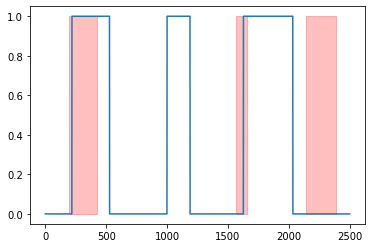

In [33]:
i = np.random.randint(0, Y_test.shape[0])

x = np.arange(Y_test.shape[1])
plt.fill_between(x, 0, 1, where=Y_test[i]==1, alpha=.25, color='r')
plt.plot(Y_test[i+1])

In [15]:
y_bounds[0]

[54, 548]